## Generate a saccade detector and apply the detector to the ground truth data to determine the appropriate settings.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
import plotfuncs as plf
plb.rcParams['pdf.fonttype'] = 42
plb.rcParams['image.interpolation'] = 'nearest'
plb.rcParams['image.aspect'] = 'auto'
plb.rcParams['image.cmap'] = 'BrBG'
import h5py
demo_mode = True
import warnings
warnings.filterwarnings('ignore')

In [4]:
#!rm saccade_analysis_data.hdf5 

In [5]:
#if demo_mode:
mtd = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db_22H05.hdf5','r')

### We consider the tethered flight saccades to be short duration transients that ride on top of slow changes in the left-right wingstroke responses. The goal of the saccade detector will be to separate the slow and transient components of the wing-stroke in a way consistent with our prior subjective classification of these events.

### The notion that that there are slow and fast components to the wingstroke suggests that we apply linear frequency filters to extract these components, however it also makes sense to think about the kinematics from a statistical sense: saccades represent outliers from the ongoing behavior. Here we applied both approaches the example trace shown in figure xxx.

In [6]:
# load the example trial shown in the open_loop_motion analysis figure
example_trial = 2
sub_samples = 20

trial_names = np.array(mtd['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    return np.array(mtd['normed_signals'][signal][selection,:])

data_selection = get_selection_mtrx('Ph2','yaw_left')
down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)

example_signal = data_selection[down_samp_idx,:][example_trial,:]

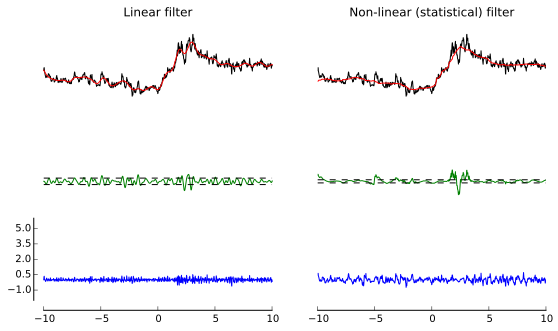

In [7]:
# plot the example trial compare linear vs. non-linear fitering approaches 
plb.figure(figsize = (9,5))
import flylib as flb
import scipy
xi = gd.get_xio('yaw_left')

############################
############################
## from the roc analysis below
lc = 1.0 #Hz low-cut
hc = 3.5 #Hz high-cut
thresh = 0.31461538461538463

sfc = flb.butter_bandpass_filter(example_signal,lc,hc,0.021)
lfc = flb.butter_lowpass_filter(example_signal,lc,0.021)
hfc = flb.butter_highpass_filter(example_signal,hc,0.021)
############################
############################

plb.subplot(3,2,1)
plb.plot(xi,example_signal,'k');plb.plot(xi,lfc,'r');plf.kill_spines()
plb.gca().set_xbound(-10,10)
plb.gca().set_title('Linear filter')

plb.subplot(3,2,3,sharey = plb.gca())
plb.plot(xi,sfc,'g');plf.kill_spines()
plb.gca().set_xbound(-10,10)
plb.axhline(thresh,color = 'k',ls = '--')
plb.axhline(-thresh,color = 'k',ls = '--')

plb.subplot(3,2,5,sharey = plb.gca())
plb.plot(xi,hfc,'b');
plb.gca().set_ybound(-1,5)
plb.gca().set_xbound(-10,10)
plf.pull_ax_spines()


############################
############################
## from the roc analysis below
ks = 81, 
ms = 34, 
thresh = 0.15384615384615385
############################
############################

plb.subplot(3,2,2,sharey = plb.gca())
from scipy import signal
plb.plot(xi,example_signal,'k')
plb.gca().set_xbound(-10,10)
plb.gca().set_title('Non-linear (statistical) filter')

plb.plot(xi,signal.medfilt(example_signal,kernel_size = ks),'r')
plb.gca().set_xbound(-10,10)
plf.kill_spines()
plb.subplot(3,2,4,sharey = plb.gca())
detrend = example_signal-signal.medfilt(example_signal,kernel_size = ks)
detrend_smooth =signal.wiener(detrend,mysize = ms)

plb.plot(xi,detrend_smooth,'g');plf.kill_spines()
plb.axhline(thresh,color = 'k',ls = '--')
plb.axhline(thresh*-1,color = 'k',ls = '--')
plb.gca().set_xbound(-10,10)
plb.subplot(3,2,6,sharey = plb.gca())
plb.gca().set_xbound(-10,10)

plb.plot(xi,detrend-detrend_smooth,'b')
plb.gca().set_ybound(-2,6)
plb.gca().set_xbound(-10,10)
for ax in plb.gcf().axes:
    plb.sca(ax)

plb.gca().set_xbound(-10,10)
plf.pull_ax_spines(left= False)

plb.draw()
plb.savefig('detection_approach.pdf')

### To determine the most approprate filtering approach and setings we, will search parameter space and test the classifier results against the ground-truth left-right data that was annotated in the saccade_annotation.ipynb notebook

#### load the inspected data

In [6]:
mtd = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db_22H05.hdf5','r')
sac_mtd = h5py.File('saccade_analysis_data.hdf5','r')
gd_mtd = sac_mtd['ground_truth']
inspected = gd_mtd['inspected_trials']

def inspected_to_dict(inspected):
    "convert the hdf5 representation into nested dictionary representation"
    retdict = dict()
    [retdict.update({int(key):[np.squeeze(np.array(ar)) for ar in value.values()]}) 
                                                 for key,value in inspected.items()]
    return retdict
                     
annotated_trials = inspected_to_dict(inspected)

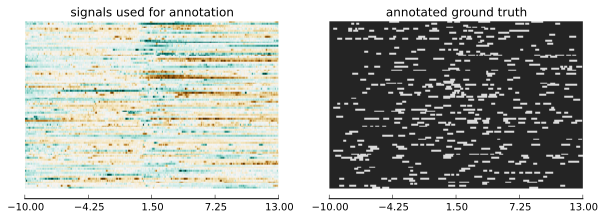

In [7]:
ground_truth_lmr = [mtd['normed_signals']['Ph2'][trace_idx] for trace_idx in annotated_trials.keys()]
ground_truth_mtrx = np.zeros_like(ground_truth_lmr)
#construct binary matrix of annotated data
for i,elist in enumerate(annotated_trials.values()):
    for event in elist:
        ground_truth_mtrx[i,event] = 1
ground_truth_mtrx = (ground_truth_mtrx>0)
plb.figure(figsize =(10,3))
plb.subplot(1,2,1)
plb.imshow(ground_truth_lmr,
           cmap = plb.cm.BrBG,vmin = -4,vmax = 4,extent = (xi[0],xi[-1],0,78))
plb.gca().set_title('signals used for annotation')
plf.pull_ax_spines(left = False);

plb.subplot(1,2,2)
plb.imshow(ground_truth_mtrx,cmap = plb.cm.gray,
           vmin = -0.2,vmax = 1.2,extent = (xi[0],xi[-1],0,78))
plb.gca().set_title('annotated ground truth')
plf.pull_ax_spines(left = False)

#### define functions to that will apply various classification schemes to the data

In [8]:
def filter_mtrx_linear(lmr_mtrx,lc,hc):
    """fiter left-right data using a bandpass filter"""
    return np.apply_along_axis(flb.butter_bandpass_filter,1,lmr_mtrx,lc,hc,0.021)

def filter_mtrx_nonlinear(lmr_mtrx,kernel_size=12,mysize=21):
    """filter using a median filter followed by wiener filter"""
    from scipy import signal
    trenddata = np.apply_along_axis(signal.medfilt,1,lmr_mtrx,kernel_size = kernel_size)
    detrend = lmr_mtrx-trenddata
    detrend[np.isnan(detrend)] = 0
    return np.apply_along_axis(signal.wiener,1,detrend,mysize =mysize)
    
def detect_saccades(lmr_mtrx,p0=0.5,p1=2,thresh=0.2,linear = True):
    """filter data then detect saccades over some threshold"""
    if linear:
        sac_band = filter_mtrx_linear(lmr_mtrx,p0,p1)
    else:
        sac_band = filter_mtrx_nonlinear(lmr_mtrx,p0,p1)
    event_lists = [flb.idx_by_thresh(sweep,thresh) for sweep in abs(sac_band)]
    event_lists = [[event for event in event_list if 
                    (len(event)>0) and not(event is None)] for event_list in event_lists if event_list]
    return event_lists,sac_band

def convert_events_to_mtrx(event_lists,output_shape,scalings = 1):
    """loop through the detected events to create a matrix of binary
    classified samples - output shape should match the dimensions matrix
    of wingstroke data that was input to the detect_saccades function"""
    event_mtrx = np.zeros(output_shape)
    if type(scalings) is list:
        for i,(elist,slist) in enumerate(zip(event_lists,scalings)):
            for event,scailing in zip(elist,slist):
                event_mtrx[i,event] = scailing
        return event_mtrx
    for i,elist in enumerate(event_lists):
        for event in elist:
            event_mtrx[i,event] = scalings
    return (event_mtrx > 0)

def get_putative_saccade_mtrx(p0,p1,thresh,linear = True):
    """apply detect_saccades and then convert to matrix use to evaluate true positive
    and false positive rates"""
    putative_saccades = detect_saccades(ground_truth_lmr,p0,p1,thresh,linear)
    putative_saccade_mtrx = convert_events_to_mtrx(putative_saccades[0],np.shape(ground_truth_lmr))
    return (putative_saccade_mtrx > 0)

In [9]:
#!rm saccade_classifier_param_search.hdf5

#### define the parameter search grid

In [14]:
thresh_vals_lin = np.linspace(0.01,1,40)
lcuts = np.linspace(0.01,2,6)
hcuts  = np.linspace(3,10,6)
    
thresh_vals_nl = np.linspace(0,1.5,40)
ksizes  = np.array([11,21,41,81,161,321]).astype(int)
mysizes = np.arange(10,100,6)

#### search over the grid, store the results in the hdf5 file 'saccade_classifier_param_search.hdf5'

In [15]:
if demo_mode:
    search_results = h5py.File('saccade_classifier_param_search.hdf5','r')
    lin_results = search_results['classifications_linear']
    nl_results = search_results['classifications_nonlinear']
else:
    import os
    os.remove('saccade_classifier_param_search.hdf5')
    search_results = h5py.File('saccade_classifier_param_search.hdf5','a')
    
    print('performing linear classification')
    thresh_vals_lin = thresh_vals_lin
    lcuts = lcuts
    hcuts  = hcuts
    
    ########################################################
    ########################################################
    classifications_linear = [[[get_putative_saccade_mtrx(lc,hc,t,linear = True) 
                                for lc in lcuts]
                                    for hc in hcuts]
                                       for t in thresh_vals_lin]
    ########################################################
    ########################################################
    
    classifications_linear = np.array(classifications_linear)
    lin_results = search_results.create_dataset('classifications_linear',
                                                data = classifications_linear,
                                                compression = 'gzip')
    lin_results.attrs['lcuts'] = lcuts
    lin_results.attrs['hcuts'] = hcuts
    lin_results.attrs['thresh_vals'] = thresh_vals_lin
    search_results.flush()
    del(classifications_linear)
    
    print('performing non-linear classification')
    thresh_vals_nl = thresh_vals_nl
    ksizes  = ksizes
    mysizes = mysizes
    
    ########################################################
    ########################################################    
    classifications_nonlinear = [[[get_putative_saccade_mtrx(k,m,t,linear = False)
                                   for k in ksizes] 
                                      for m in mysizes]
                                         for t in thresh_vals_nl]
    ########################################################
    ########################################################  

    classifications_nonlinear = np.array(classifications_nonlinear)
    nl_results = search_results.create_dataset('classifications_nonlinear',
                                               data = classifications_nonlinear,
                                               compression = 'gzip')
    nl_results.attrs['ksizes'] = ksizes
    nl_results.attrs['mysizes'] = mysizes
    nl_results.attrs['thresh_vals'] = thresh_vals_nl
    search_results.flush()
    del(classifications_nonlinear)

performing linear classification
performing non-linear classification


### Now evaluate the results of the search by plotting evaluation of ROC curves that plot the TRP and FPR distributions for all values of the threshold.

In [16]:
#chose a filter type to evaluate
filter_mode = 'non_linear'
#filter_mode = 'linear'

In [21]:
# assign the linear or non-linear results to classifications
# depending whether we are evaluating the linear or non-linear filter
classifications = {'linear':lin_results,
                   'non_linear':nl_results}

#### we'll use an ROC curve to evaluate the result of each filter since the number of true positives and false positives should go up as the threshold decreases.

In [22]:
def get_TPR_FPR(p0,p1,t_idx,mode):
    """Calculate the true positive rate and true negative rate, 
    consider each sampled data-point a separate 'test' not that this
    evaluation is not sensitive to wheter a detected saccade is continous or not.
    nor does it penalize for polarity discrepancies."""
    mkey = {0:'linear',1:'non_linear'}[mode]
    putative_saccade_mtrx = classifications[mkey][t_idx,p1,p0] #get_putative_saccade_mtrx(thresh,ksize,mysize)
    FP = np.sum(~(ground_truth_mtrx>0) & (putative_saccade_mtrx>0)) #false positives
    FN = np.sum(~(putative_saccade_mtrx>0) & (ground_truth_mtrx>0)) #false negatives
    TP = np.sum((ground_truth_mtrx>0) & (putative_saccade_mtrx>0)) #true positives
    TN = np.sum(~(ground_truth_mtrx>0) & ~(putative_saccade_mtrx>0)) #true negatives
    TPR = float(TP)/(TP+FN) #true positive rate
    FPR = float(FP)/(FP+TN) #true negative rate
    return TPR,FPR

In [38]:
def plot_ROC_curve(p0,p1,t_idxs,t_idx = 0,mode = 0,plot_pnt = False):
    """plot the TPR vs FPR distributions as a function of t"""
    c = {0:'green',1:'blue'}[mode]
    lw = {True:2.5,False:1.0}[plot_pnt]
    alpha = {True:1.0,False:0.5}[plot_pnt]
    roc_data = np.array([get_TPR_FPR(p0,p1,t,mode) for t in t_idxs]).T
    plb.plot(np.sort(roc_data[1]),np.sort(roc_data[0]),color = c,lw = lw,alpha = alpha)
    if plot_pnt:
        plb.plot(roc_data[1][t_idx],roc_data[0][t_idx],'o')

#### define a function to plot the roc cuve for a given filer setting and explore the parameter search interactively in the notebook using the notebook interactive function

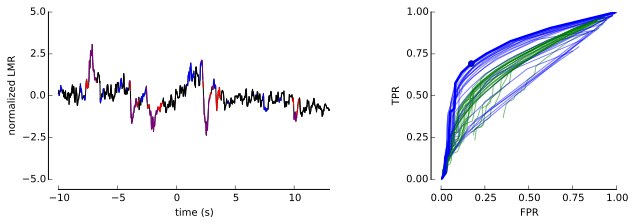

In [53]:
from ipywidgets import *

xo = gd.get_xio('yaw_left')
from matplotlib import gridspec
gs = gridspec.GridSpec(1,6)

params = dict()
[params.update({x[0]:(0,len(x[1])-1)}) for x in 
             zip(['p0','p1','thresh'],classifications['linear'].attrs.values())]
params.update({'sweep':(0,np.shape(ground_truth_lmr)[0]-1)})
params.update({'mode':{'linear':0,'non_linear':1}})
thresh_vals = classifications['linear'].attrs['thresh_vals']

def plot_setting(p0,p1,thresh,sweep,mode):
    mkey = {0:'linear',1:'non_linear'}[mode]
    fig = plb.figure(figsize = (10,3))
    fig.add_subplot(gs[0,:3])
    lmr = ground_truth_lmr[sweep]
    xo = gd.get_xio('yaw_right')#np.linspace(0,len(lmr)*0.021,len(lmr))
    
    idx = classifications[mkey][thresh,p1,p0,sweep]
    plb.plot(xo,lmr,'k',clip_on = False)
    
    sac = lmr.copy();
    
    tpos = lmr.copy()
    tneg = lmr.copy()
    fneg = lmr.copy()
    fpos = lmr.copy()
    
    tpos[~(ground_truth_mtrx[sweep]&idx)] = np.nan
    tneg[~((~ground_truth_mtrx[sweep])&(~idx))] = np.nan
    fpos[~(idx&(~ground_truth_mtrx[sweep]))] = np.nan
    fneg[~(ground_truth_mtrx[sweep]&(~idx))] = np.nan
    
    #sac[~idx] = np.nan
    
    
    tneg[ground_truth_mtrx[sweep]] = np.nan
    
    plb.plot(xo,tpos,'purple',lw = 1,clip_on = False)
    plb.plot(xo,tneg,'k',lw = 1,clip_on = False)
    plb.plot(xo,fpos,'b',lw = 1,clip_on = False)
    plb.plot(xo,fneg,'r',lw = 1,clip_on = False)
    
    plb.gca().set_xbound(-10,13)
    plb.gca().set_xlabel('time (s)')
    plb.gca().set_ylabel('normalized LMR')
    #plb.gca().set_xticknumbers(10)
    plb.gca().set_ybound(-5,5)
    plf.pull_ax_spines()
    plb.gca().set_xticks(np.linspace(-10,10,5))
    
    
    fig.add_subplot(gs[0,4:])
    for px0 in np.arange(0,params['p0'][1]):
        for px1 in np.arange(0,params['p1'][1]):
            plot_ROC_curve(px0,px1,
                           np.arange(len(thresh_vals)),
                           t_idx = thresh,
                           mode = 0,
                           plot_pnt = False)
            
            plot_ROC_curve(px0,px1,
                           np.arange(len(thresh_vals)),
                           t_idx = thresh,
                           mode = 1,
                           plot_pnt = False)
            
    plot_ROC_curve(p0,p1,np.arange(len(thresh_vals)),t_idx = thresh,mode = mode,plot_pnt = True)
    plb.gca().set_xbound(0,1)
    plb.gca().set_ybound(0,1)
    plb.gca().set_xlabel('FPR')
    plb.gca().set_ylabel('TPR')
    plf.pull_ax_spines()
    
    #gca().set_ybound(-1,2)
w = interactive(plot_setting,**params)
from IPython.display import display
display(w)

In [54]:
#create a dictionary with the chosen settings
filter_mode  = {0:'linear',1:'non_linear'}[w.kwargs['mode']]
chosen_settings = dict()

if filter_mode is 'linear':
    [chosen_settings.update({ak:lin_results.attrs[ak][w.kwargs[wk]]}) for 
       ak,wk in zip(['lcuts','hcuts','thresh_vals'],['p0','p1','thresh'])]
    chosen_settings['mode'] = filter_mode
else:
    [chosen_settings.update({ak:nl_results.attrs[ak][w.kwargs[wk]]}) for 
       ak,wk in zip(['ksizes','mysizes','thresh_vals'],['p0','p1','thresh'])]
    chosen_settings['mode'] = filter_mode

In [55]:
w.kwargs

{'mode': 1, 'p0': 3, 'p1': 4, 'sweep': 47, 'thresh': 4}

In [56]:
chosen_settings

{'ksizes': 81,
 'mode': 'non_linear',
 'mysizes': 34,
 'thresh_vals': 0.15384615384615385}

In [57]:
#print the true positive and true negative rates for the chosen settings
get_TPR_FPR(w.kwargs['p0'],w.kwargs['p1'],w.kwargs['thresh'],mode = w.kwargs['mode'])

(0.6920221228880976, 0.1720468211869193)

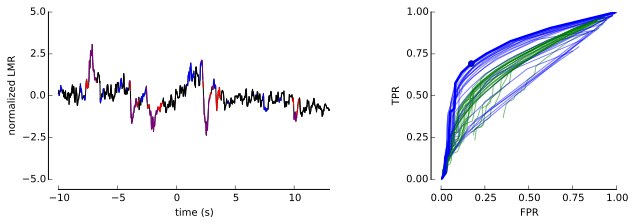

In [58]:
#save a plot for the paper
plot_setting(**w.kwargs)
plb.savefig('saccade_evaluation.pdf')

In [59]:
#store the selected filter setting in a dictionary. Pickle for later use
import cPickle
with open('chosen_fiter_settings.cpkl','wb') as f:
    cPickle.dump(chosen_settings,f)